In [159]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import math
import seaborn as sns
import plotly.graph_objects as go


In [160]:
#Reading data
#Spanish data from spanish health ministry, all hisotrical series
data = pd.read_csv(r"https://covid19.isciii.es/resources/serie_historica_acumulados.csv",skipfooter=3,error_bad_lines=False,encoding = 'ANSI')

data.columns = ['CCAA Codigo ISO','Fecha','Casos Old','Casos','TestAc','Hospitalizados','UCI','Fallecidos','Recuperados']
#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Cataluña data
data_cat = pd.read_csv(r"https://analisi.transparenciacatalunya.cat/api/views/jj6z-iyrp/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true", sep=";",encoding = 'utf-8')

#Spanish data from Madrid
data_madrid = pd.read_csv(r"https://datos.comunidad.madrid/catalogo/dataset/7da43feb-8d4d-47e0-abd5-3d022d29d09e/resource/b2a3a3f9-1f82-42c2-89c7-cbd3ef801412/download/covid19_tia_muni_y_distritos.csv", sep=";",encoding = 'ANSI')

#datos de renta por municipios
data_renta_municipios = pd.read_csv(r"C:\Users\guillermo.arguello\Documents\Covid Analisys\renta_municipios.csv", sep="|",encoding = 'ANSI')

#datos población paises

data_poblacion = pd.read_excel('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx',
                                    sheet_name="ESTIMATES",skiprows= 16)

data_poblacion = data_poblacion[["Region, subregion, country or area *","2020"]]

data["Casos"] =  np.where(data["Casos"].isna(), data["Casos Old"],data["Casos"])


In [161]:
#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)


In [162]:
data_jh = data_jh.dropna()
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")
data_jh["Casos"] = pd.to_numeric(data_jh["Casos"])
data_jh["Fallecidos"] = pd.to_numeric(data_jh["Fallecidos"])
data_jh["Recuperados"] = pd.to_numeric(data_jh["Recuperados"])
data_jh["Country/Region"] = data_jh["Country/Region"].astype(str)

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)

data_jh = pd.merge(data_jh, data_poblacion, how= 'left',left_on=['Country/Region'], 
                   right_on = ['Region, subregion, country or area *'])

data_jh = data_jh.set_index('Fecha')
data_jh["Incremento porcentual de casos respecto al total"]= data_jh["Diferencia casos dia anterior"]/data_jh["Casos"]*100
data_jh["Incremento porcentual de fallecidos respecto al total"]= data_jh["Diferencia fallecidos dia anterior"]/data_jh["Fallecidos"]*100

data_jh = data_jh.rename(columns={"2020": "2020 Population"})

data_jh["Fallecidos por millón habitantes"]= data_jh["Fallecidos"]/(data_jh["2020 Population"]/1000)


data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=False).mean()

In [163]:
data = data.fillna(0)
data.drop(data[ data['Fecha'] == 0 ].index , inplace=True)
data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y").sort_values()
data['Diferencia casos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Casos"]
data['Diferencia hospitalizados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Hospitalizados"]
data['Diferencia UCI dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["UCI"]
data['Diferencia fallecidos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Fallecidos"]
data['Diferencia recuperados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Recuperados"]

data = data.fillna(0)
data_es = data.groupby('Fecha', as_index=False).sum()
data_es = data_es.set_index('Fecha')
data_es = data_es[data_es["Fallecidos"] > 10]
data_es["Incremento porcentual de casos respecto al total"]= (data_es["Diferencia casos dia anterior"]/data_es["Casos"]*100).round(3)
data_es["Incremento porcentual de fallecidos respecto al total"]= (data_es["Diferencia fallecidos dia anterior"]/data_es["Fallecidos"]*100).round(3)

data_sem = data_es.rolling(7, center=False).mean()


In [164]:
data_cat["Data"] = pd.to_datetime(data_cat["TipusCasData"], format="%d/%m/%Y").sort_values()
data_cat_gropued = data_cat.groupby('Data',as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued = data_cat_gropued[data_cat_gropued["Data"] > "2020-03-01"]
data_cat_gropued = data_cat_gropued.set_index('Data')
data_cat_gropued_resultado = data_cat.groupby(['Data',"TipusCasDescripcio"],as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued_resultado = data_cat_gropued_resultado[data_cat_gropued_resultado["Data"] > "2020-03-01"]
data_cat_gropued_resultado = data_cat_gropued_resultado.set_index('Data')

In [165]:
#Procasamiento datos Madrid
data_madrid = data_madrid[["municipio_distrito","fecha_informe","casos_confirmados_totales","tasa_incidencia_acumulada_total"]]
data_madrid = data_madrid.dropna()
data_madrid["municipio_distrito"]= data_madrid["municipio_distrito"].str.strip()
data_renta_municipios["MUNICIPIO"]= data_renta_municipios["MUNICIPIO"].str.strip()

data_renta_municipios = data_renta_municipios[["MUNICIPIO","RENTA DISPONIBLE MEDIA","NUMERO HABITANTES"]]
data_mad = pd.merge(data_madrid, data_renta_municipios, how= 'left',left_on=['municipio_distrito'], 
                   right_on = ['MUNICIPIO'])

data_mad["tasa_incidencia_acumulada_total"] = data_mad["tasa_incidencia_acumulada_total"].str.replace(",",".")
data_mad["tasa_incidencia_acumulada_total"] = pd.to_numeric(data_mad["tasa_incidencia_acumulada_total"])
data_mad["NUMERO HABITANTES"] = data_mad["NUMERO HABITANTES"].str.replace(".","")
data_mad["NUMERO HABITANTES"] = pd.to_numeric(data_mad["NUMERO HABITANTES"])


#data_mad = data_mad.dropna(subset = ["RENTA BRUTA MEDIA"])
#data_mad = data_mad.dropna()


data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85 , "Renta Categorical"] = 'Renta Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1), "Renta Categorical"] = 'Renta Media-Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25), "Renta Categorical"] = 'Renta Media-Media'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5), "Renta Categorical"] = 'Renta Media-Alta'

data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] > data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5, "Renta Categorical"] = 'Renta Alta'


data_mad = data_mad[data_mad["NUMERO HABITANTES"] > 1000] 
data_mad = data_mad[data_mad["casos_confirmados_totales"] > 20] 


In [166]:
data_es.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_es_historical_series.csv')
data_jh.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\john_hopkins_university_historical_series.csv')
data_cat_gropued.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_catalunya.csv')
data_mad.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_madrid.csv')


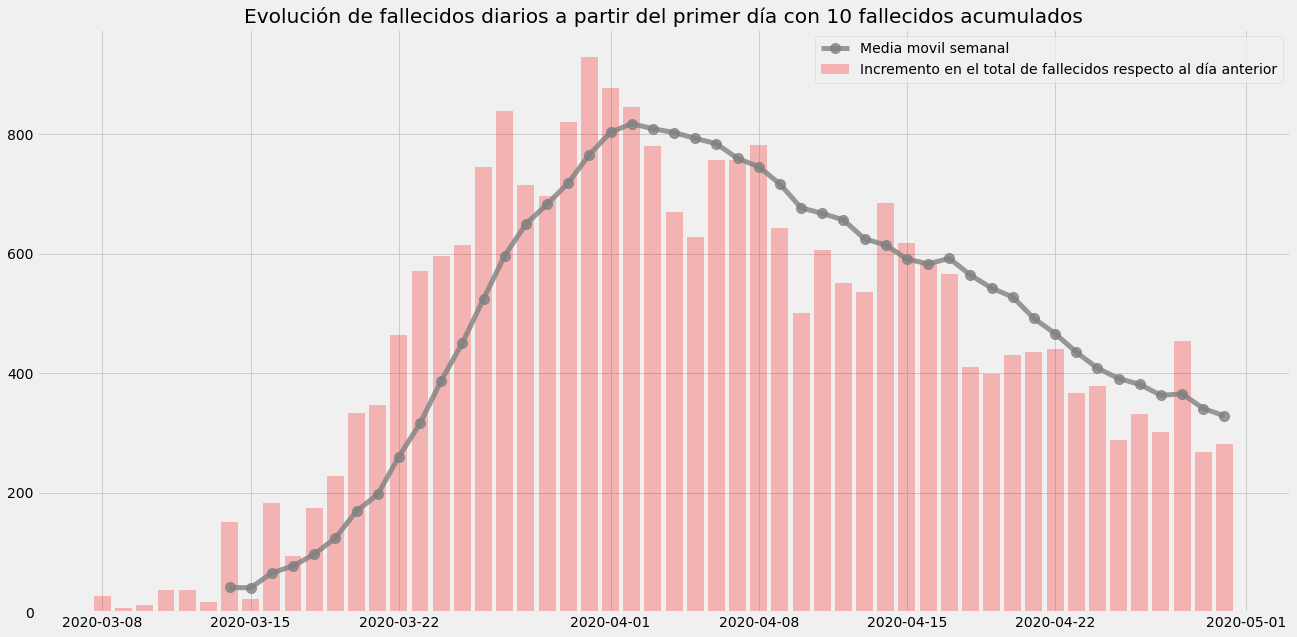

In [167]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia fallecidos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia fallecidos dia anterior"],width=0.8, alpha=0.25, color='red',
       label='Incremento en el total de fallecidos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de fallecidos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos.png');



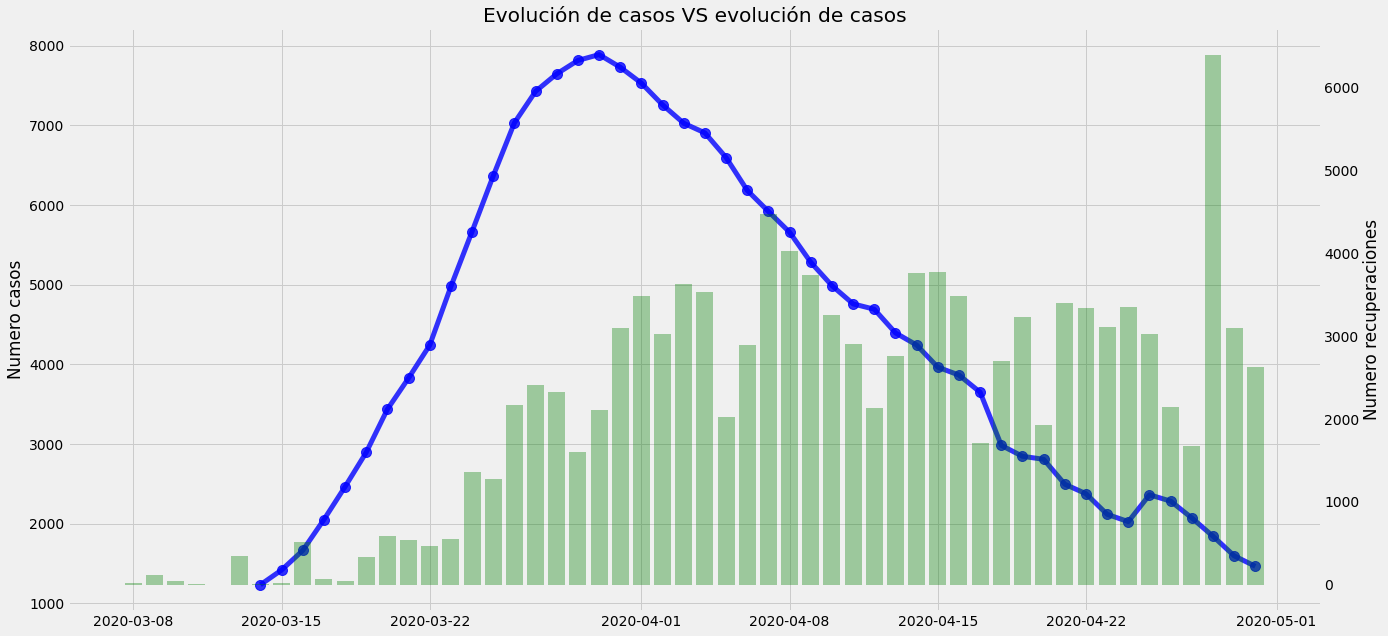

In [168]:
# Let's build our plot
# Set up plot 

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis

#Next lines plot the line of the plot

ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=0.8,color='blue',
         label='Incremento en el total de casos respecto al día anterior',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_sem.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.35, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')


ax2.grid(b=False) # turn off grid #2

ax1.set_title('Evolución de casos VS evolución de casos')
ax1.set_ylabel('Numero casos')
ax2.set_ylabel('Numero recuperaciones');



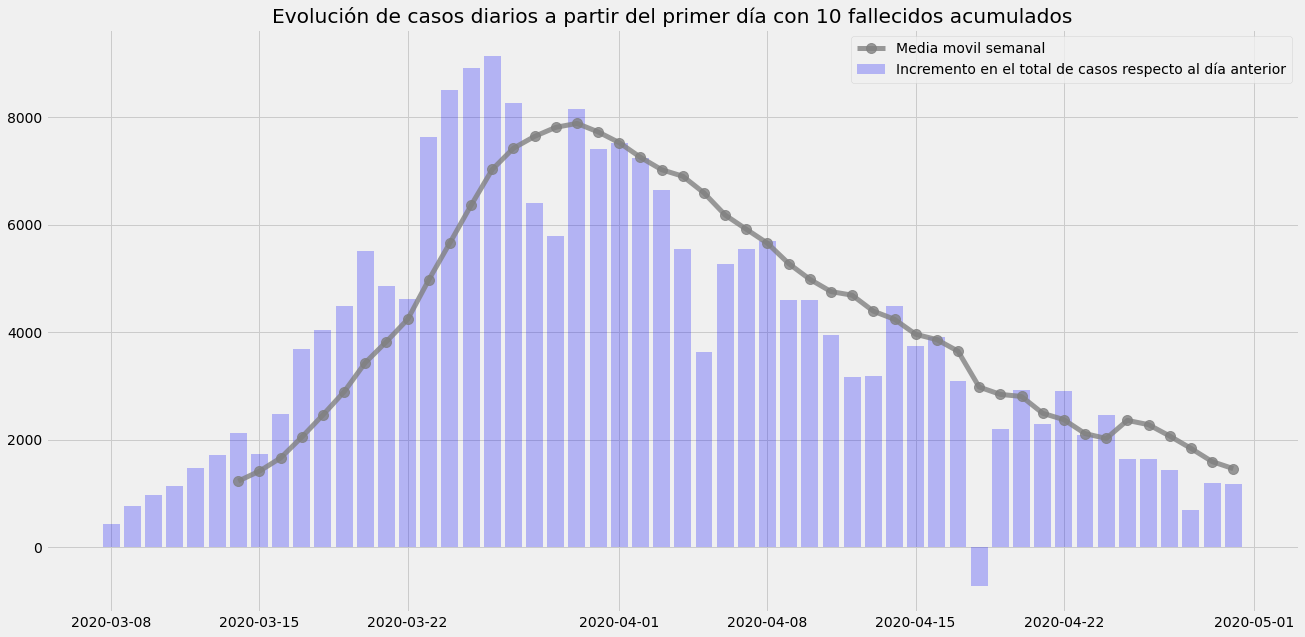

In [169]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia casos dia anterior"],width=0.8, alpha=0.25, color='blue',
       label='Incremento en el total de casos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos.png');




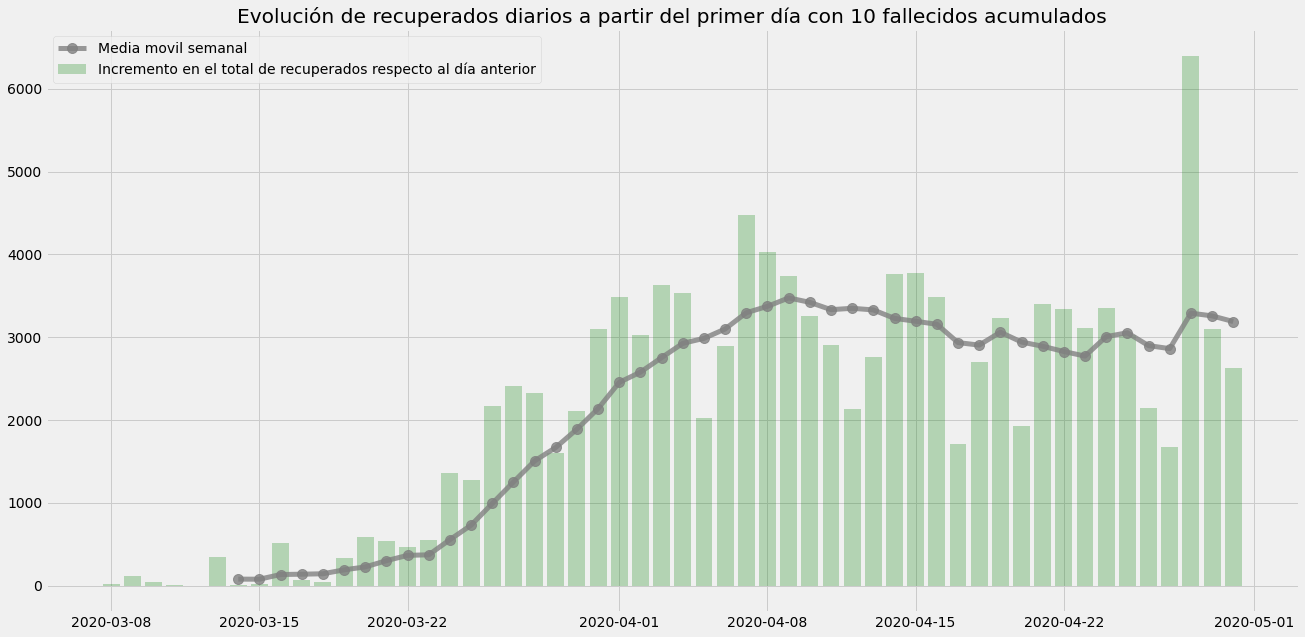

In [170]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia recuperados dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.25, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de recuperados diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\recuperados.png');


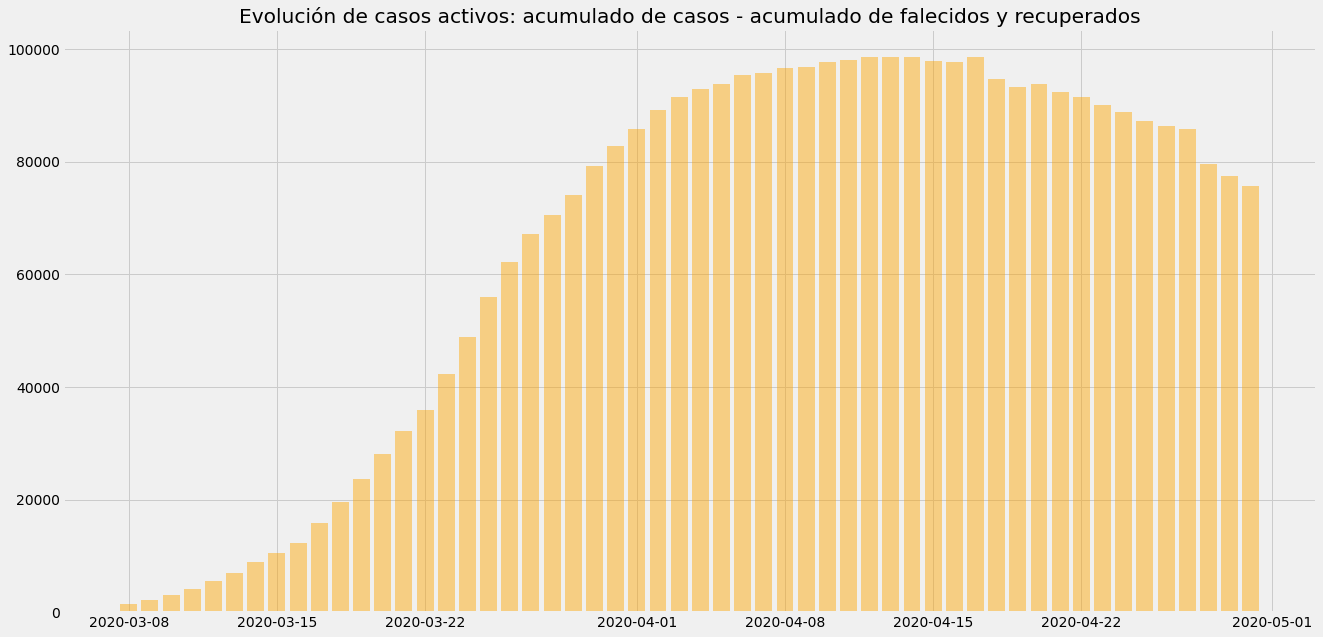

In [171]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Casos"] - data_es["Fallecidos"] - data_es["Recuperados"],
        width=0.8, alpha=0.45, color='orange')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos activos: acumulado de casos - acumulado de falecidos y recuperados')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_activos.png');


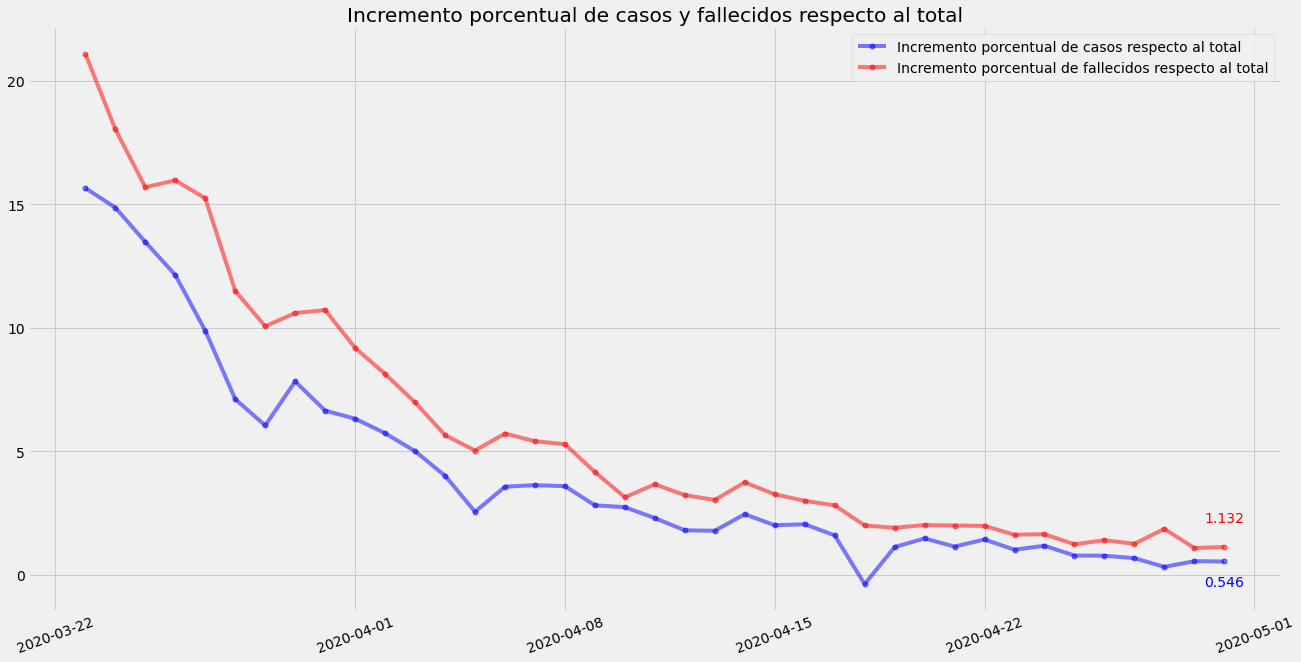

In [172]:
start, end = '2020-03-23 00:00:00', data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-',alpha=0.5,color='blue',
        label='Incremento porcentual de casos respecto al total')

ax.plot(data_es.loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, alpha=0.5,color='red',linestyle='-', label='Incremento porcentual de fallecidos respecto al total')

plt.xticks(rotation=20)
plt.title("Incremento porcentual de casos y fallecidos respecto al total")

plt.annotate(data_es.loc[end, 'Incremento porcentual de casos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de casos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center',color='blue') # horizontal alignment can be left, right or center
plt.annotate(data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,25), # distance from text to points (x,y)
                 ha='center',color='red') # horizontal alignment can be left, right or center

ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\incremento_porcentual.png');


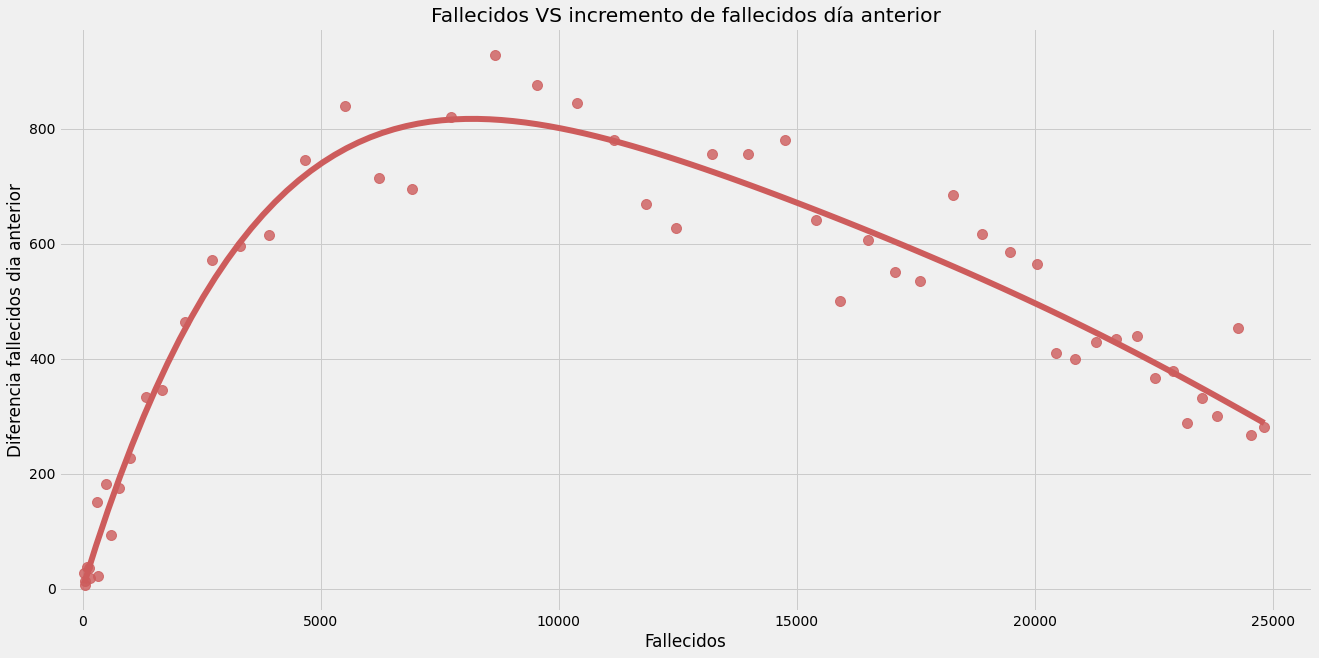

In [173]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Fallecidos']
Y = data_es.loc[start:end, 'Diferencia fallecidos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=False,color='indianred')
plt.title("Fallecidos VS incremento de fallecidos día anterior")
ax.set(xlim=(-500, data_es["Fallecidos"].max() + 1000))
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos_VS_incremento.png');



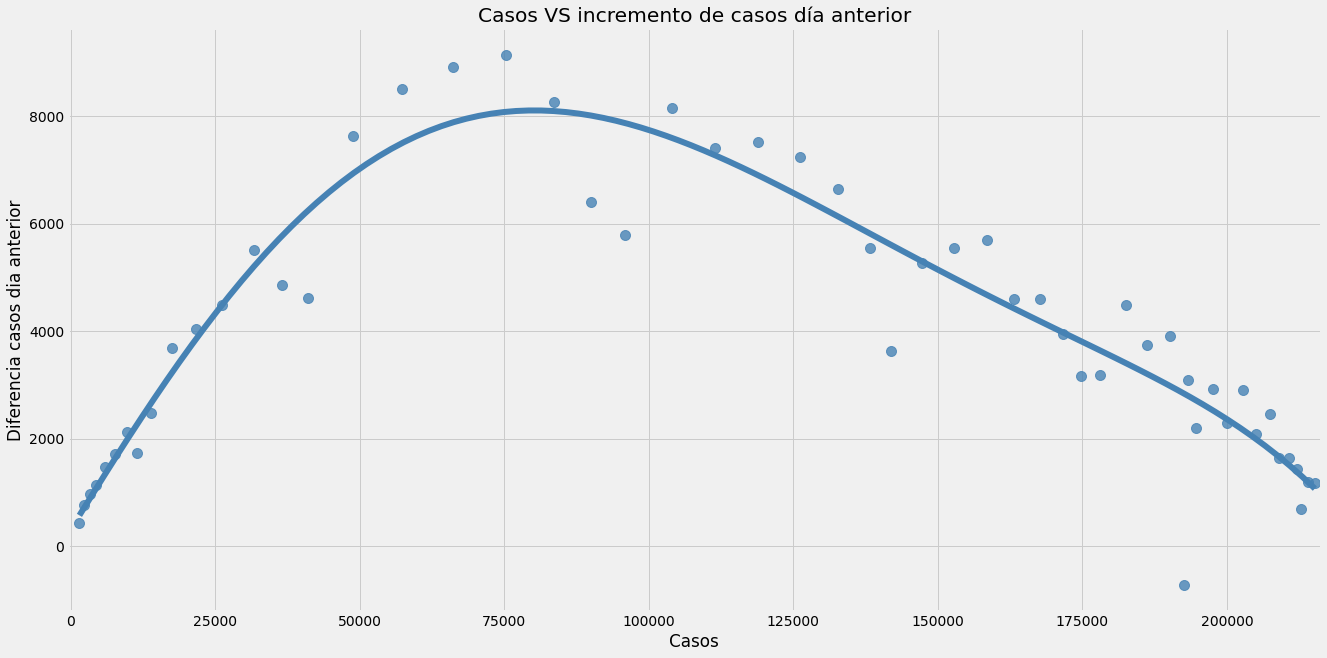

In [174]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Casos']
Y = data_es.loc[start:end, 'Diferencia casos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=True,color='steelblue')
ax.set(xlim=(-500, data_es["Casos"].max() + 1000))

plt.title("Casos VS incremento de casos día anterior")
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_VS_incremento.png');



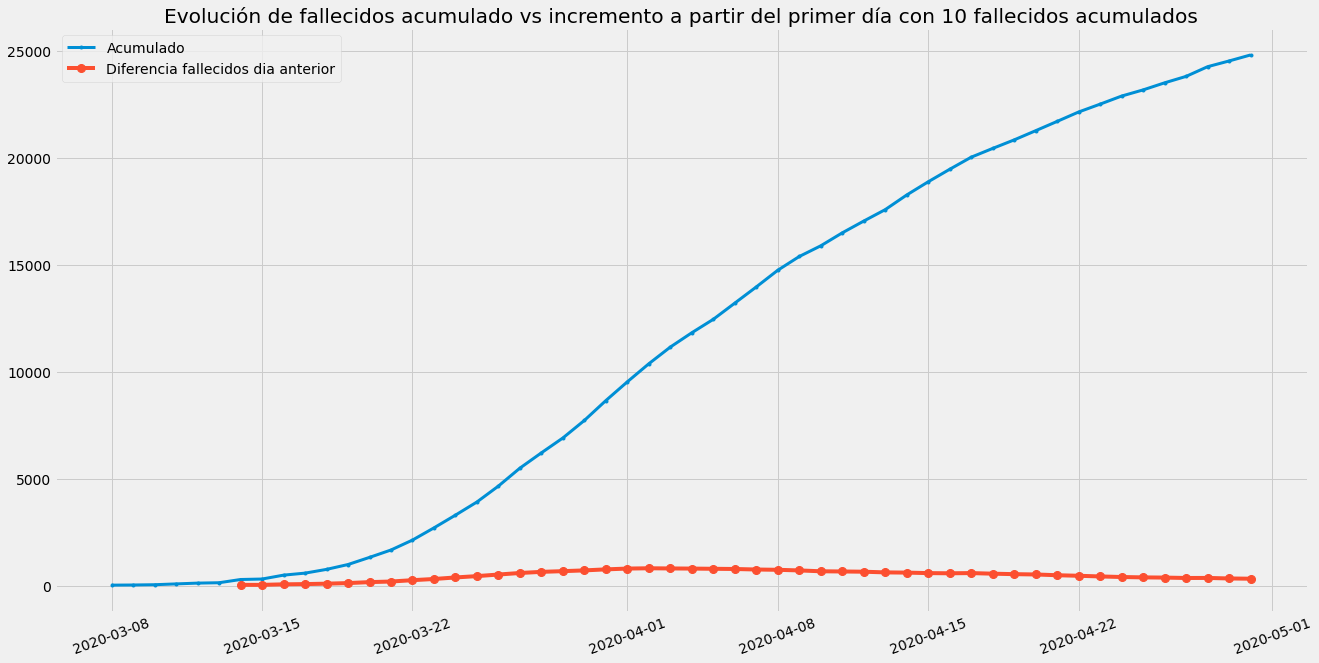

In [175]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='.', linestyle='-', linewidth=3, label='Acumulado')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=8, linestyle='-', label='Diferencia fallecidos dia anterior')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos acumulado vs incremento a partir del primer día con 10 fallecidos acumulados")
ax.legend();

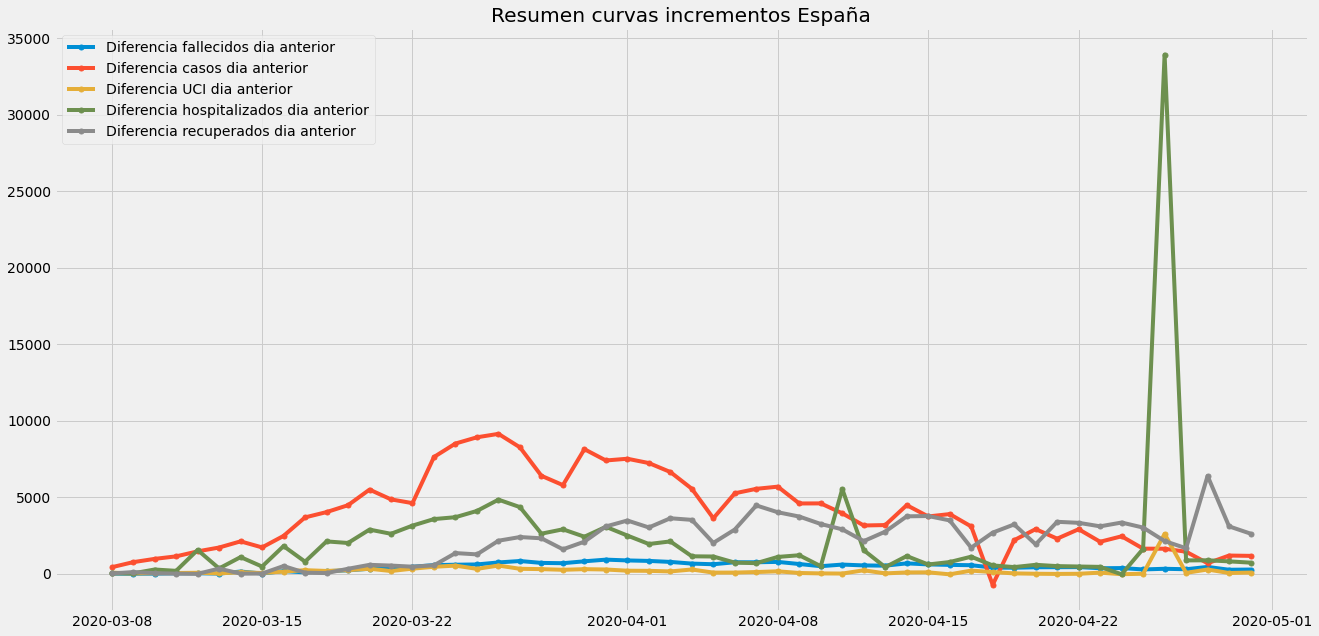

In [176]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
plt.title("Resumen curvas incrementos España");
ax.legend();

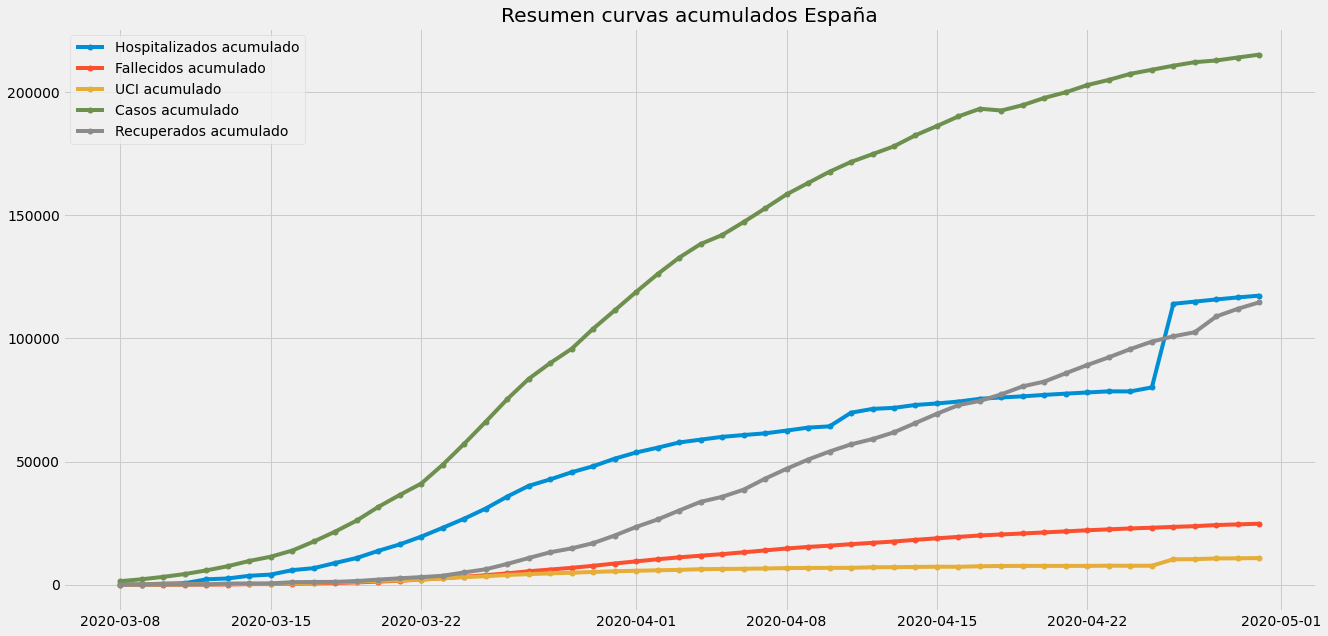

In [177]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data_es.loc[start:end, 'Hospitalizados'],
marker='o', markersize=5, linestyle='-', label='Hospitalizados acumulado')
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='o', markersize=5, linestyle='-', label='Fallecidos acumulado')
ax.plot(data_es.loc[start:end, 'UCI'],
marker='o', markersize=5, linestyle='-', label='UCI acumulado')
ax.plot(data_es.loc[start:end, 'Casos'],
marker='o', markersize=5, linestyle='-', label='Casos acumulado')
ax.plot(data_es.loc[start:end, 'Recuperados'],
marker='o', markersize=5, linestyle='-', label='Recuperados acumulado')
plt.title("Resumen curvas acumulados España");
ax.legend();

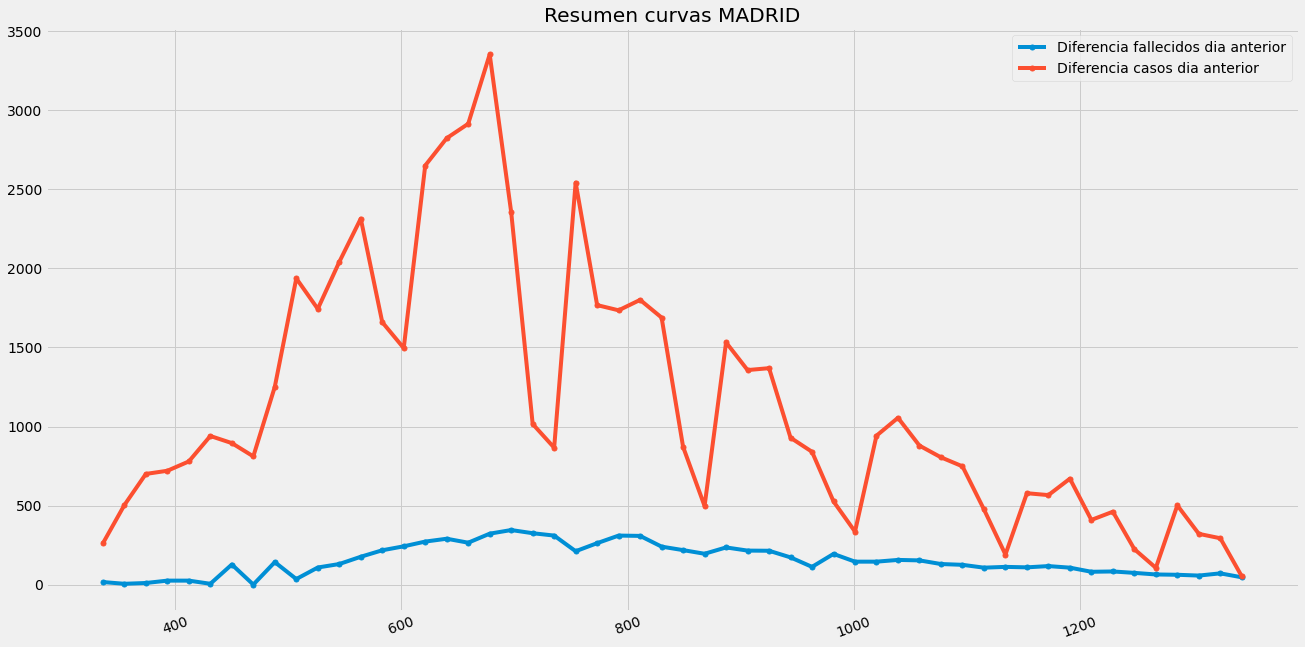

In [178]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "MD"].index.min(), data[data["CCAA Codigo ISO"] == "MD"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "MD"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "MD"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')

ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas MADRID");

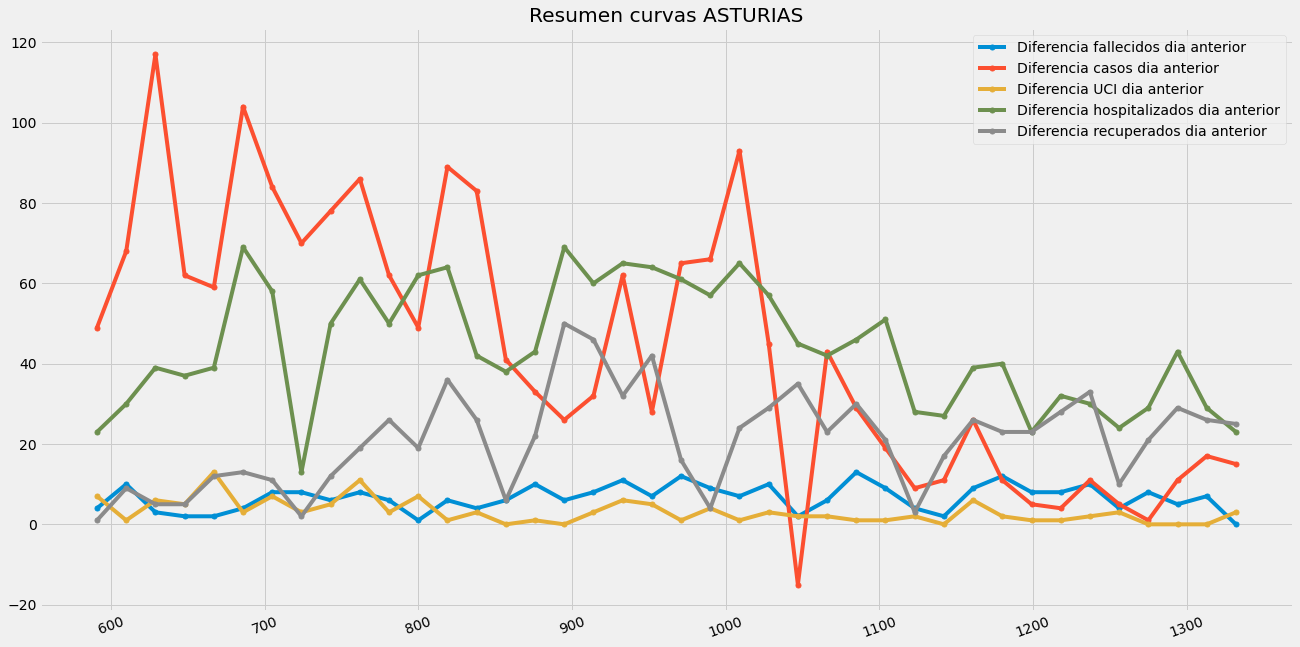

In [179]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "AS"].index.min(), data[data["CCAA Codigo ISO"] == "AS"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas ASTURIAS");

Casos positivos: 0.0
Casos Sospechosos: 0.0
Numero de tests totales: 0.0


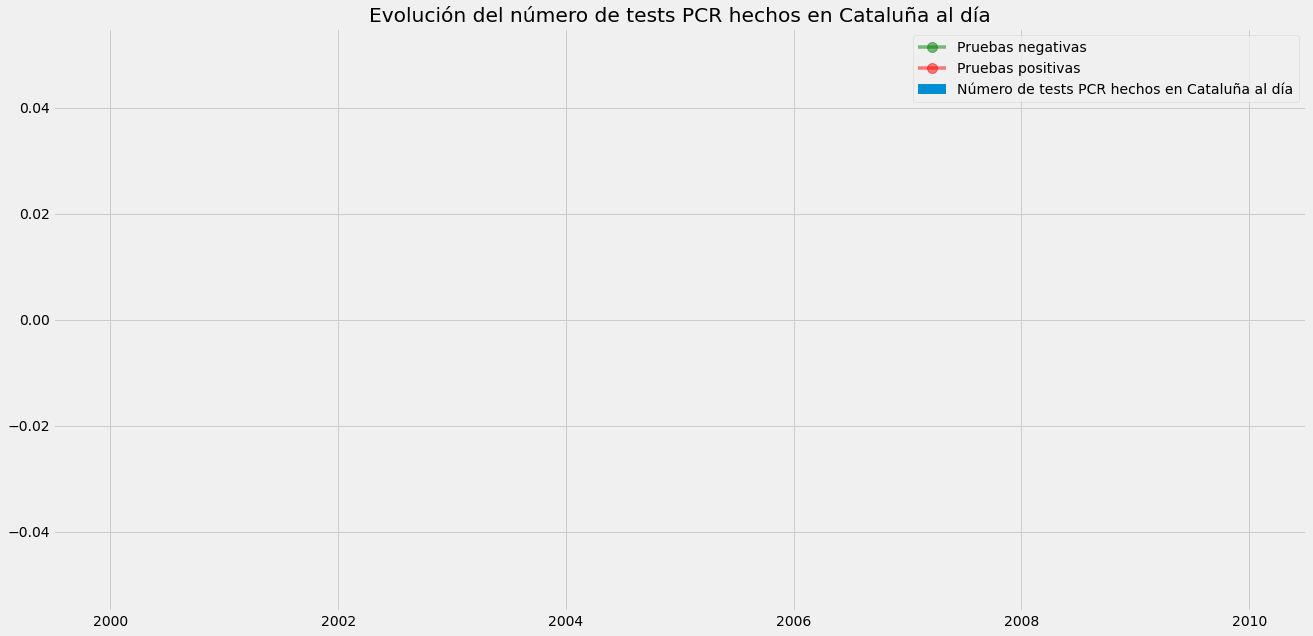

In [180]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"]
         ,alpha=0.5,color='green',
         label='Pruebas negativas',marker='o', markersize=10,linewidth=3.5)

ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"]
         ,alpha=0.5,color='red',
         label='Pruebas positivas',marker='o', markersize=10,linewidth=3.5)


#Next lines plot the bar chat part of the plot
ax2.bar(data_cat_gropued.index, data_cat_gropued["NumCasos"],width=0.8, alpha=0.2, color='blue',
       label='Número de tests PCR hechos en Cataluña al día')

ax1.grid(b=True) #Turn on grid

print ("Casos positivos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"].sum())
print ("Casos Sospechosos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"].sum())
print ("Numero de tests totales:", data_cat_gropued_resultado["NumCasos"].sum())

#set up the title and legend
ax1.set_title('Evolución del número de tests PCR hechos en Cataluña al día')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\tests.png');



In [181]:
data_sem_jh = data_sem_jh[data_sem_jh["Fallecidos"] >= 10]
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh = data_sem_jh.set_index('Fecha')
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh["Time_delta"] = 0
data_sem_jh["Time_delta"] = pd.to_timedelta(data_sem_jh["Time_delta"])


In [182]:
for geo in data_sem_jh["Country/Region"].unique():
    data_sem_out = data_sem_jh[data_sem_jh["Country/Region"] == geo]
    data_sem_out["Time_delta"] = data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"] - data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"].min()
    data_sem_jh[data_sem_jh["Country/Region"] == geo] = data_sem_out[data_sem_out["Country/Region"] == geo]

In [183]:
data_sem_jh["Time_delta"] = data_sem_jh["Time_delta"].astype('timedelta64[D]')
data_sem_jh = data_sem_jh.set_index('Time_delta')


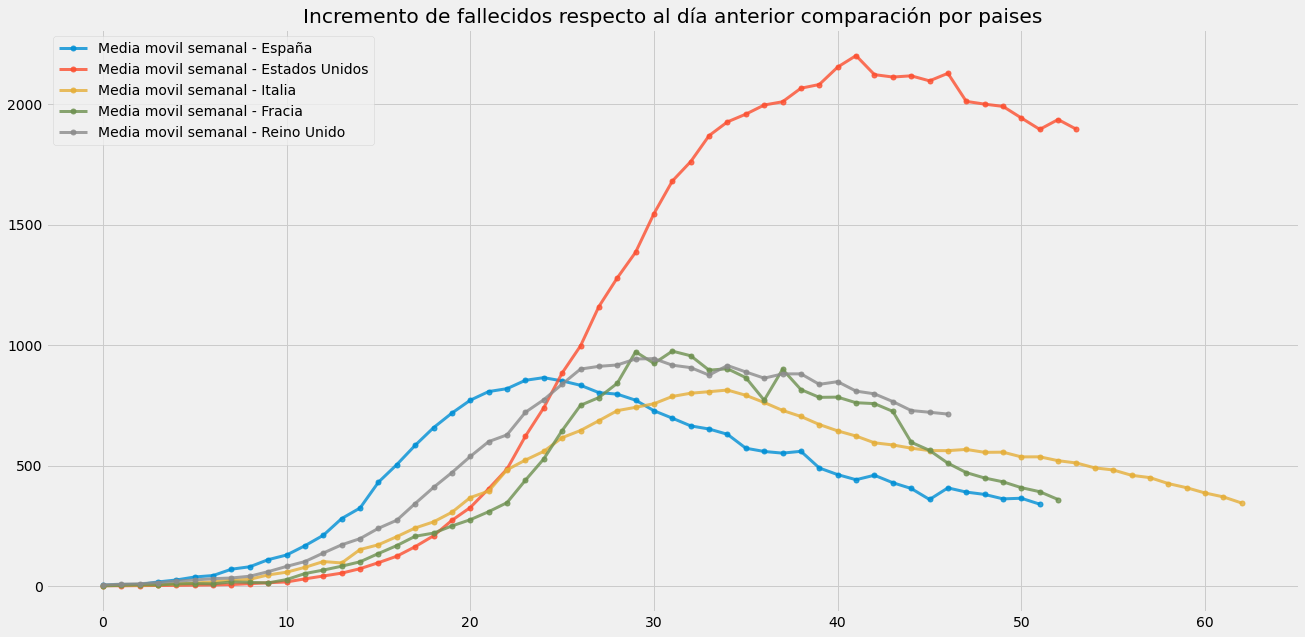

In [184]:
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - España')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Estados Unidos')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Italia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8 ,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Fracia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") 
                    & (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Reino Unido')

plt.title("Incremento de fallecidos respecto al día anterior comparación por paises")
ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\paises.png');

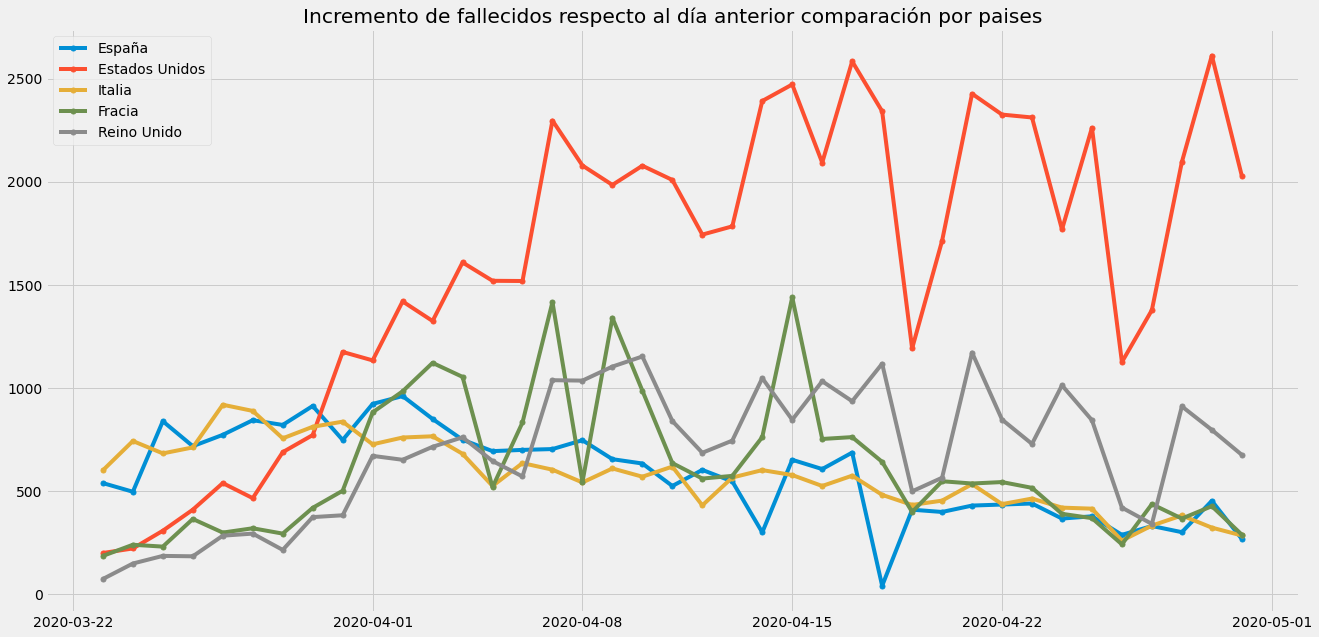

In [185]:
start, end = '2020-03-23 00:00:00', data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_jh[(data_jh["Country/Region"] == "US") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_jh[(data_jh["Country/Region"] == "Italy") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_jh[(data_jh["Country/Region"] == "France") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_jh[(data_jh["Country/Region"] == "United Kingdom") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de fallecidos respecto al día anterior comparación por paises");
ax.legend();

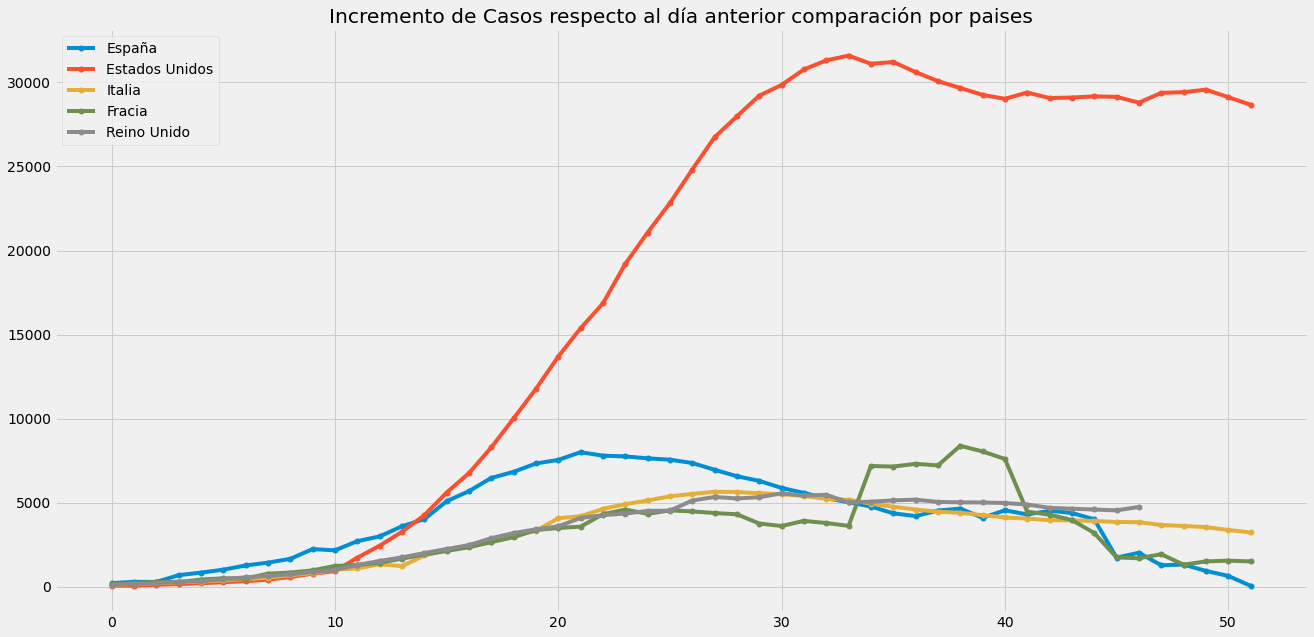

In [186]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de Casos respecto al día anterior comparación por paises");
ax.legend();

In [187]:
data_jh[["Country/Region","Diferencia casos dia anterior"]].sort_values("Diferencia casos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia casos dia anterior
Fecha,,
2020-04-24,US,36188.0
2020-04-09,US,34126.0
2020-04-10,US,33755.0
2020-04-04,US,33283.0
2020-04-25,US,32796.0
2020-04-18,US,32491.0
2020-04-17,US,32114.0
2020-04-03,US,31745.0
2020-04-08,US,31533.0


In [188]:
data_jh[["Country/Region","Diferencia fallecidos dia anterior"]].sort_values("Diferencia fallecidos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia fallecidos dia anterior
Fecha,,
2020-04-29,US,2612.0
2020-04-17,US,2584.0
2020-04-15,US,2472.0
2020-04-21,US,2427.0
2020-04-14,US,2392.0
2020-04-18,US,2342.0
2020-04-22,US,2326.0
2020-04-23,US,2312.0
2020-04-07,US,2297.0


In [189]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

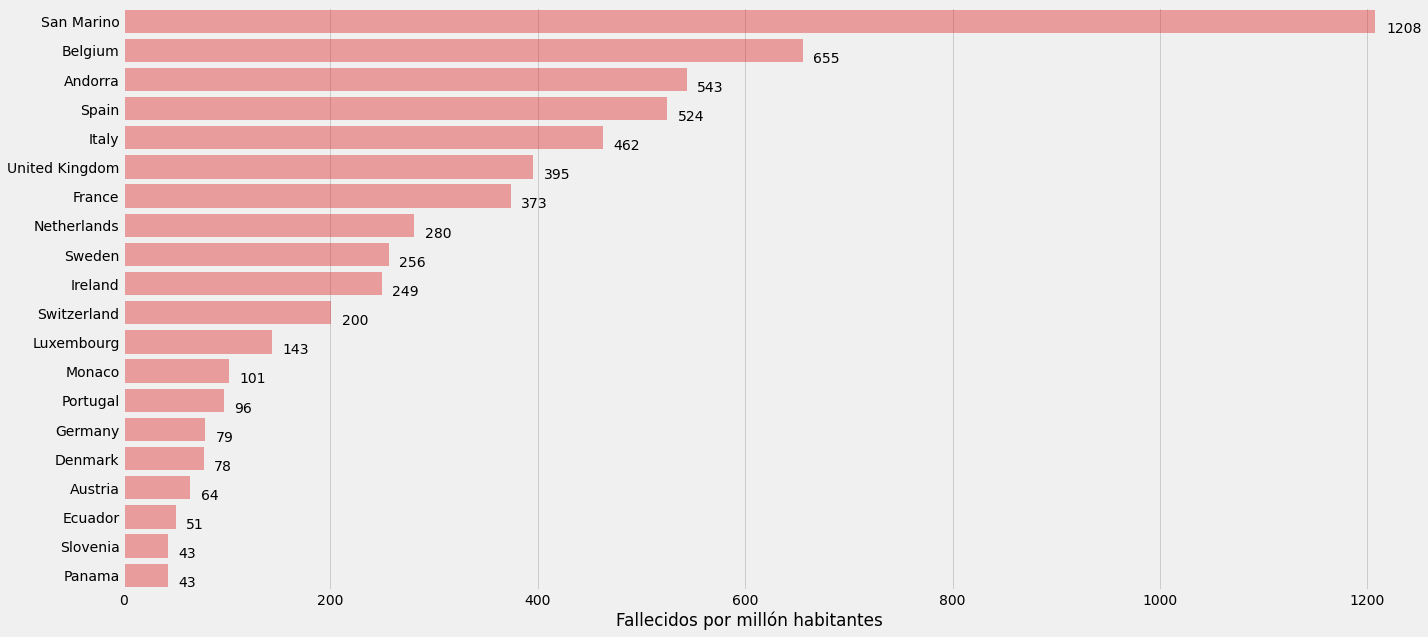

In [190]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20,10))

# Load the example car crash dataset
df = data_jh.groupby(["Country/Region"]).max()["Fallecidos por millón habitantes"].sort_values(ascending=False).to_frame().reset_index().head(20)

# Plot the total crashes
sns.barplot(x="Fallecidos por millón habitantes", y="Country/Region", data=df,
            label="Total", color="r", alpha=0.4)



# Add a legend and informative axis label
ax.set(xlim=(0, df["Fallecidos por millón habitantes"].max()), ylabel="",
       xlabel="Fallecidos por millón habitantes")
show_values_on_bars(ax, "h", 10);


In [191]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Fallecidos"] > 25].loc[fecha, ["Country/Region","Fallecidos",
                                                'Incremento porcentual de fallecidos respecto al total']].sort_values(by='Incremento porcentual de fallecidos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar fallecidos"] = 100/df["Incremento porcentual de fallecidos respecto al total"]

df["Días que tarda en doblar fallecidos"] = df["Días que tarda en doblar fallecidos"].round(3)
df["Incremento porcentual de fallecidos respecto al total"] = df["Incremento porcentual de fallecidos respecto al total"].round(3)

df

,Country/Region,Fallecidos,Incremento porcentual de fallecidos respecto al total,Días que tarda en doblar fallecidos
Fecha,,,,
2020-04-30,Serbia,179,30.168,3.315
2020-04-30,Nigeria,58,12.069,8.286
2020-04-30,Pakistan,385,10.909,9.167
2020-04-30,Peru,1051,10.276,9.731
2020-04-30,Sudan,31,9.677,10.333
2020-04-30,Russia,1073,9.413,10.624
2020-04-30,Brazil,6006,8.208,12.183
2020-04-30,Kuwait,26,7.692,13.000
2020-04-30,Honduras,71,7.042,14.200


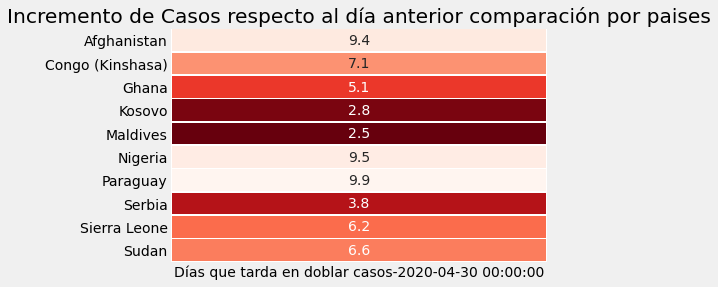

In [192]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Casos"] > 100].loc[fecha, ["Country/Region","Casos",
                                                'Incremento porcentual de casos respecto al total']].sort_values(by='Incremento porcentual de casos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar casos"] = 100/df["Incremento porcentual de casos respecto al total"]

df["Días que tarda en doblar casos"] = df["Días que tarda en doblar casos"].round(3)
df["Incremento porcentual de casos respecto al total"] = df["Incremento porcentual de casos respecto al total"].round(3)
df = df.loc[:, df.columns != 'Casos']
df = df.loc[:, df.columns != 'Incremento porcentual de casos respecto al total']
df = df.sort_values(by='Días que tarda en doblar casos',ascending=False)
df = df.reset_index().pivot("Country/Region","Fecha")
ax = sns.heatmap(df, annot=True,cmap="Reds_r", linewidths=.5,cbar=False)
plt.title("Incremento de Casos respecto al día anterior comparación por paises")
plt.ylabel('')
plt.xlabel('');



In [193]:
df

,Días que tarda en doblar casos
Fecha,2020-04-30
Country/Region,
Afghanistan,9.358
Congo (Kinshasa),7.062
Ghana,5.146
Kosovo,2.765
Maldives,2.463
Nigeria,9.471
Paraguay,9.852
Serbia,3.787


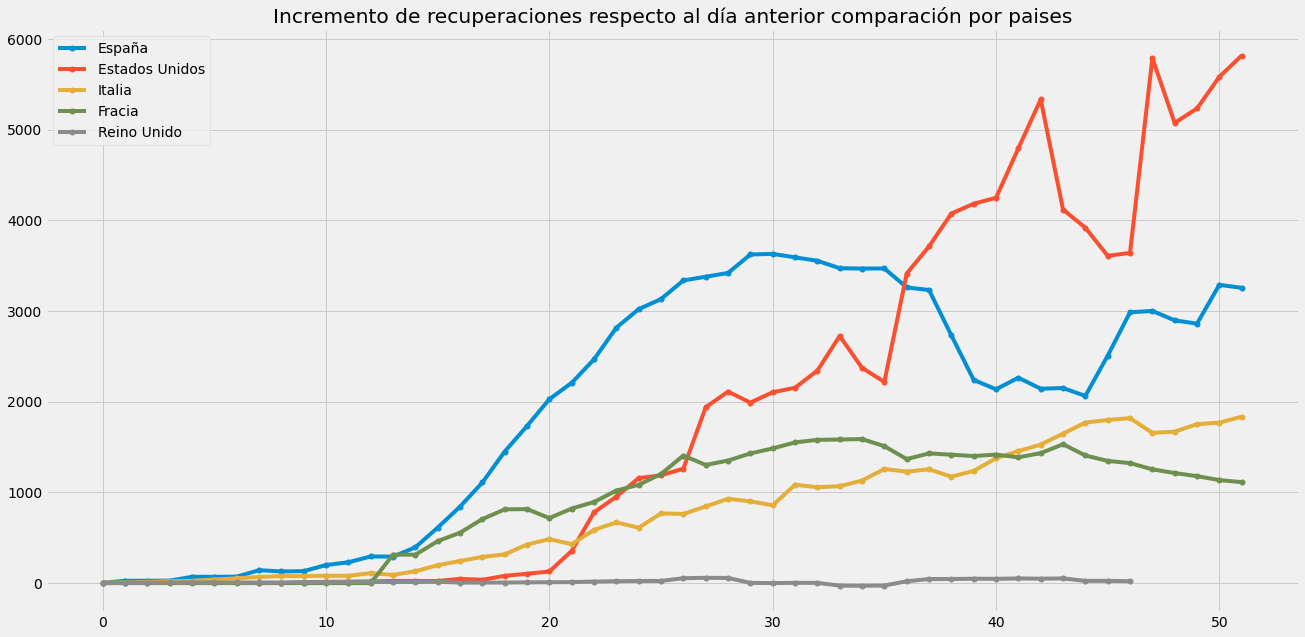

In [194]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de recuperaciones respecto al día anterior comparación por paises");
ax.legend();

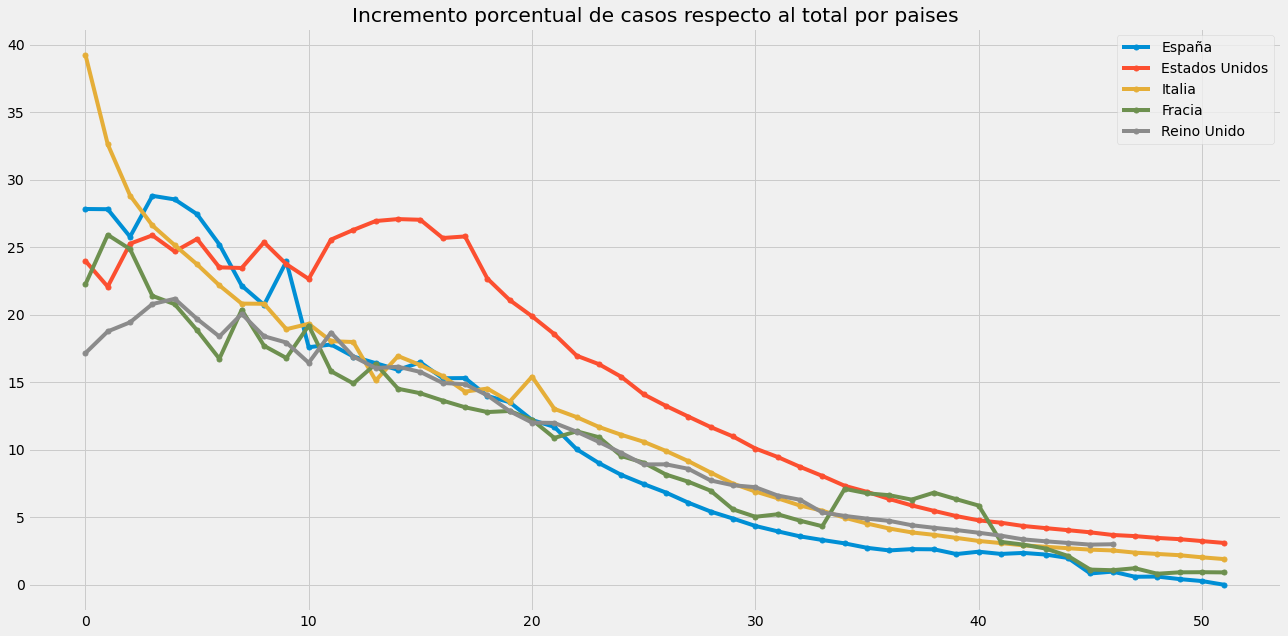

In [195]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de casos respecto al total por paises");
ax.legend();

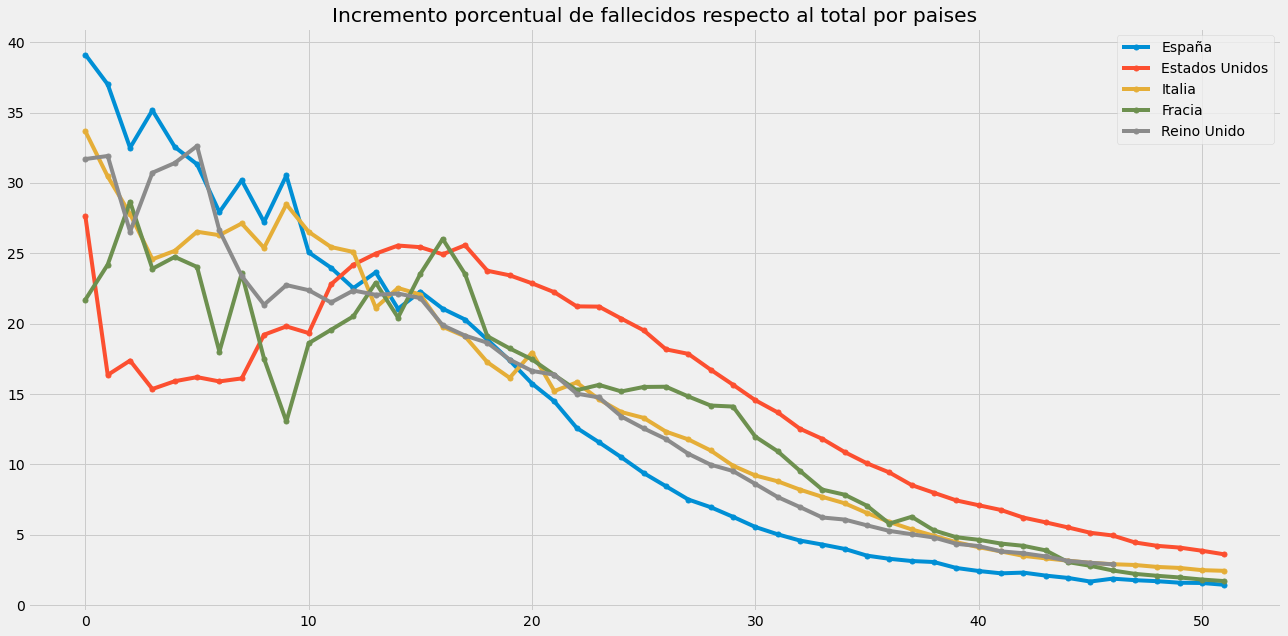

In [196]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de fallecidos respecto al total por paises");
ax.legend();

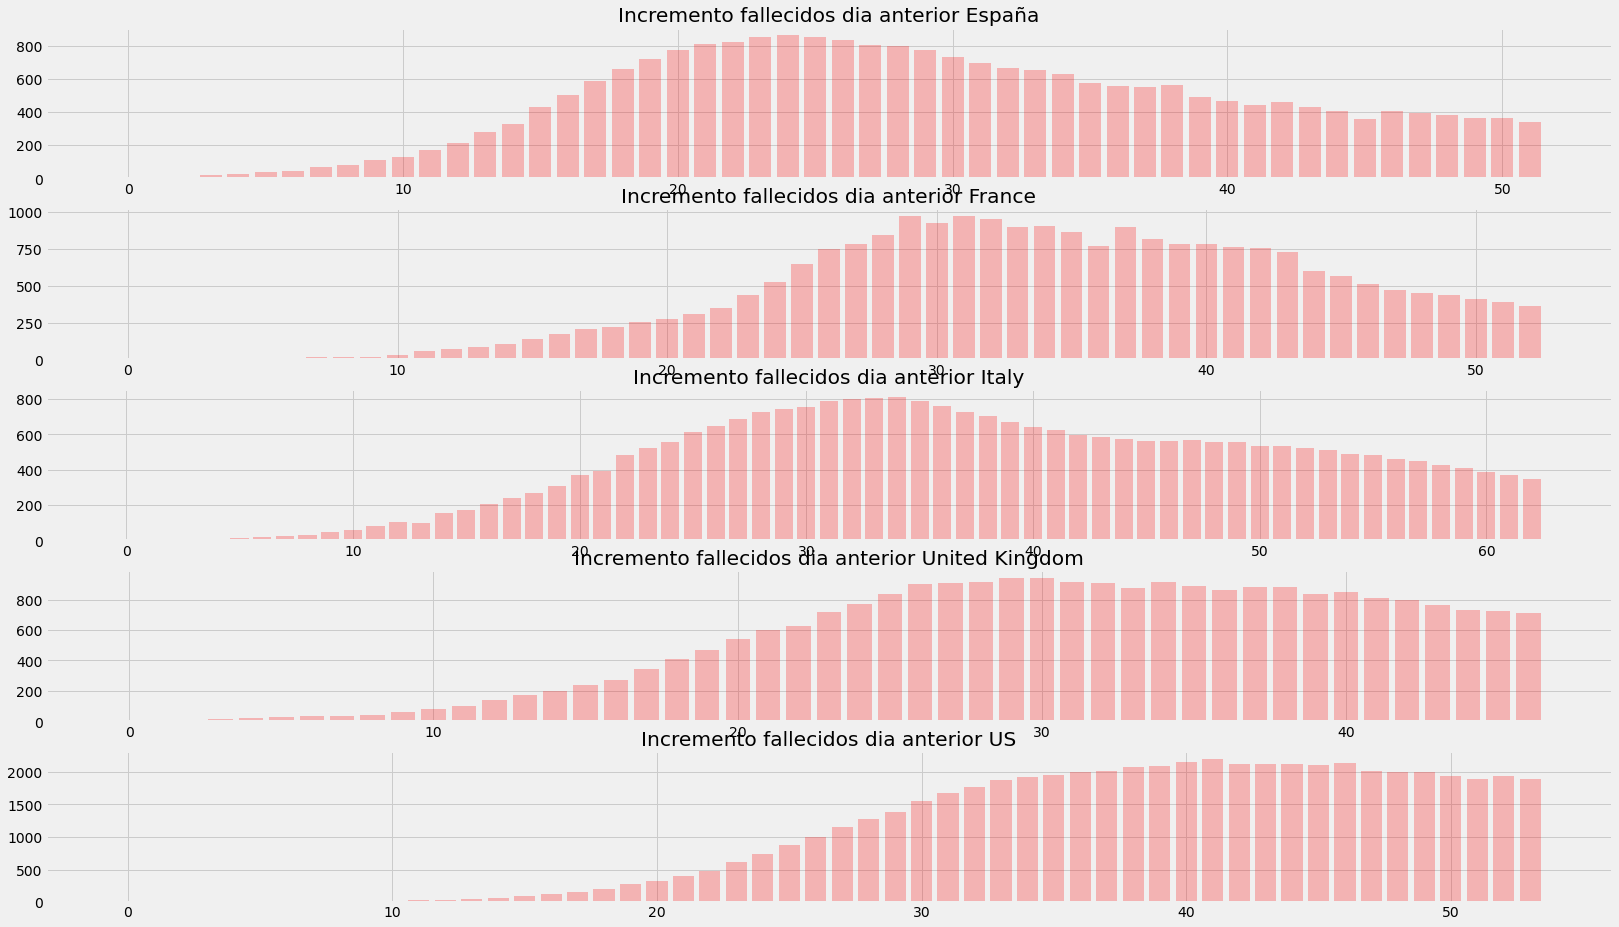

In [197]:
start, end = data_sem_jh.index.min(), data_sem_jh.index.max()
# Let's build our plot
# Set up plot 
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(25,15))

#Next lines plot the bar chat part of the plot
ax1.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Spain"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Spain"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax2.bar(data_sem_jh[data_sem_jh["Country/Region"] == "France"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "France"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax3.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Italy"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Italy"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax4.bar(data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"].loc[start: end].index, 

        data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax5.bar(data_sem_jh[data_sem_jh["Country/Region"] == "US"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "US"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Incremento fallecidos dia anterior España')
ax2.set_title('Incremento fallecidos dia anterior France')
ax3.set_title('Incremento fallecidos dia anterior Italy')
ax4.set_title('Incremento fallecidos dia anterior United Kingdom')
ax5.set_title('Incremento fallecidos dia anterior US');


In [198]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


In [199]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
data_sem.index.freq="D"
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:311.06679284751624
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1184.1261817645463
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:187.53567454001654
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:49.58746201961991
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:204.06445211627826
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1287.419408604678
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:42.44653334730183
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:34.668676507611664
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:251.14936107310217
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1617.1625307174777
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:130.12268248670378
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3.614282850402684
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:225.66651392692282
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:15.86887423981624
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3.5870167651689666
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-41.66923810354562
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1793.4989821444094
ARIMA(0, 1, 

In [200]:
mod2 = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   54
Model:               SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  24.090
Date:                                Fri, 01 May 2020   AIC                            -44.181
Time:                                        11:58:15   BIC                            -41.516
Sample:                                    03-08-2020   HQIC                           -43.366
                                         - 04-30-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2234      0.257      0.869      0.385      -0.280       0.727
sig

Fecha
2020-04-09    746.244971
2020-04-10    735.250050
2020-04-11    685.736288
2020-04-12    684.215624
2020-04-13    651.140692
2020-04-14    617.718066
2020-04-15    571.781383
2020-04-16    561.557866
2020-04-17    549.704499
2020-04-18    565.478557
2020-04-19    525.372410
2020-04-20    511.626434
2020-04-21    502.186985
2020-04-22    455.578683
2020-04-23    457.195084
2020-04-24    424.012144
2020-04-25    385.098849
2020-04-26    384.083492
2020-04-27    369.436359
2020-04-28    360.818711
2020-04-29    377.437084
2020-04-30    324.546058
Freq: D, dtype: float64
2020-05-01    318.160533
2020-05-02    311.450694
2020-05-03    288.972768
2020-05-04    275.534731
2020-05-05    254.307685
2020-05-06    236.706702
2020-05-07    227.377107
2020-05-08    221.366120
2020-05-09    209.822853
2020-05-10    211.909969
Freq: D, dtype: float64


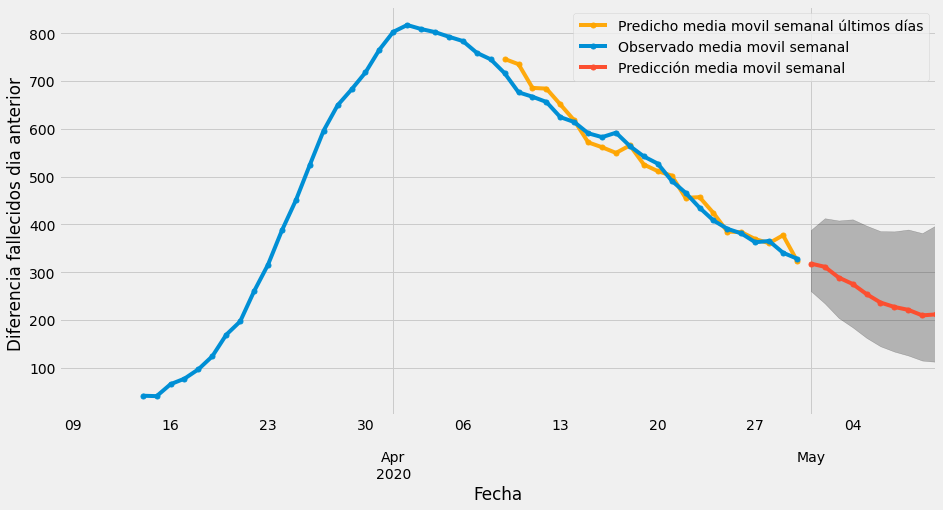

In [201]:
pred_uc_prev = results2.get_prediction(start=pd.to_datetime('2020-04-09 00:00:00'))

pred_uc_prev = math.e**pred_uc_prev.predicted_mean
print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho media movil semanal últimos días',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_sem["Diferencia fallecidos dia anterior"].plot(label='Observado media movil semanal', figsize=(14, 7),marker='o', markersize=5)
pred_uc.plot(ax=ax, label='Predicción media movil semanal',marker='o', markersize=5)
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción_media_movil.png');

plt.show()


In [202]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:340.61926954394534
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:241.43886804980485
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:149.85892375854155
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:758.4439350547226
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:156.02446017626139
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:150.58414397960698
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:42.07940766725017
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1140.8125137014524
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:276.9780750205235
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:187.08952611223856
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:117.14561275663758
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:935.9605755668174
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:134.09175105714655
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:125.49614896831653
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:25.483989894438473
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:945.494308307018
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:91.52475580195176
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-21.55064365643007

In [203]:
mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   54
Model:                 SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  -0.297
Date:                                Fri, 01 May 2020   AIC                              4.593
Time:                                        11:58:27   BIC                              7.328
Sample:                                    03-08-2020   HQIC                             5.450
                                         - 04-30-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0081      0.098      0.082      0.934      -0.184       0.200
sig

Fecha
2020-04-08    866.698197
2020-04-09    653.477187
2020-04-10    628.143859
2020-04-11    586.909737
2020-04-12    685.779904
2020-04-13    518.329883
2020-04-14    515.165115
2020-04-15    630.405051
2020-04-16    528.451980
2020-04-17    547.852557
2020-04-18    681.913648
2020-04-19    409.366107
2020-04-20    411.359026
2020-04-21    353.367084
2020-04-22    338.175880
2020-04-23    533.401860
2020-04-24    333.099737
2020-04-25    367.106918
2020-04-26    369.594587
2020-04-27    298.082657
2020-04-28    285.616485
2020-04-29    437.618567
2020-04-30    193.683153
Freq: D, dtype: float64
2020-05-01    273.400975
2020-05-02    294.746356
2020-05-03    298.673393
2020-05-04    302.744307
2020-05-05    251.756044
2020-05-06    259.562851
2020-05-07    197.375651
2020-05-08    226.647351
2020-05-09    206.121163
2020-05-10    311.367566
Freq: D, dtype: float64


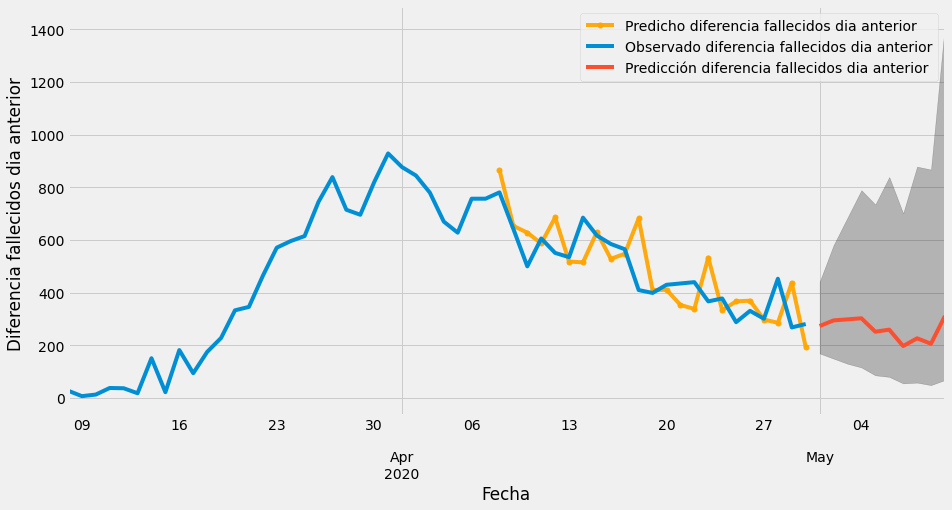

In [204]:
pred_uc_prev = results.get_prediction(start=pd.to_datetime('2020-04-08 00:00:00'))
pred_uc_prev = math.e**pred_uc_prev.predicted_mean

print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho diferencia fallecidos dia anterior',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)


pred_uc = results.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_es["Diferencia fallecidos dia anterior"].plot(label='Observado diferencia fallecidos dia anterior', figsize=(14, 7))
pred_uc.plot(ax=ax, label='Predicción diferencia fallecidos dia anterior')
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción.png')

plt.legend()
plt.show()

In [205]:
from statsmodels.formula.api import ols
data_mad= data_mad[data_mad["fecha_informe"] == data_mad["fecha_informe"].max()]
results = ols('tasa_incidencia_acumulada_total ~ data_mad["Renta Categorical"] ', data=data_mad).fit()
table = sm.stats.anova_lm(results)
table

,df,sum_sq,mean_sq,F,PR(>F)
"data_mad[""Renta Categorical""]",4.0,1.122884e+06,280721.059720,2.923634,0.024945
Residual,96.0,9.217714e+06,96017.856298,NaN,NaN


In [206]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     tasa_incidencia_acumulada_total   R-squared:                       0.109
Model:                                         OLS   Adj. R-squared:                  0.071
Method:                              Least Squares   F-statistic:                     2.924
Date:                             Fri, 01 May 2020   Prob (F-statistic):             0.0249
Time:                                     11:58:27   Log-Likelihood:                -720.10
No. Observations:                              101   AIC:                             1450.
Df Residuals:                                   96   BIC:                             1463.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            886.4435     75.154     11.795      0.000     737.264    1035.623
data_mad["Renta Categorical"][T.Renta Baja]          120.9526    114.167      1.059      0.292    -105.667     347.572
data_mad["Renta Categorical"][T.Renta Media-Alta]   -167.3669    109.769     -1.525      0.131    -385.257      50.523
data_mad["Renta Categorical"][T.Renta Media-Baja]   -152.7903     95.275     -1.604      0.112    -341.910      36.329
data_mad["Renta Categorical"][T.Renta Media-Media]  -178.4317     95.275     -1.873      0.064    -367.551      10.688
==============================================================================
Omnibus:                        3.747   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.626
Skew:                           0.461   Prob(JB):                        0.163
Kurtosis:                       2.893   Cond. No.                         6.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""